pdp and ice methods courtesy of lukas innig

In [1]:
import datarobot as dr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

In [2]:
import pandas as pd
from datarobot.codegen_wrapper import CodegenPredictor
jar = "./data/5d5da72a3fa59e2850f824fc.jar"
lid = "5d5da72a3fa59e2850f824fc"

Data preparation 
-------------------

In [3]:
df = pd.read_csv("./data/10K_Lending_Club_Loans20200608.csv", encoding="latin-1")

Making target again

Partial Dependence
---

Downloading training data predictions from DataRobot to grab validation fold rowID

In [10]:
# Function for generating feature effects from DataRobot manually
# Inputs are project object, model, desired dataset, and feature of interest.
# Returns the plot and plot data
# Sampling done by default for n > 1000 for speed purposes but can be turned off.
# size_of_grid is the number of feature values to use. Default is 25.
# grid is automatically created (quantiles for numerics, random sampling for categoricals). 
# size_of_grid can also take a vector of values for custom grids.
# Can plot ICE curves but turned off by default. Best to leave off for larger samples.
# Can also plot +/- 1 standard deviation around the average prediction.
# Can only be used for categoricals and numerics in the requested dataset (no DR derived features).
# Computing partial dependence for alcohol

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
def partial_dependence(lid, jar_location, target, target_type, data, feature, size_of_grid=25, 
                              sample_size=1000, ice_plot=False, std_dev_plot=False):
    np.random.seed(42)
    data = data.copy()
    if target_type == "Multiclass":
        raise ValueError("Feature Effects is not support for Multiclass yet.")
        
    if feature not in data.columns:
        raise ValueError("Specified feature is not found in dataset.")
        
    if sample_size:
        # Random sample if regression or if target is not included in dataset
        if (target_type == "Regression") | (target not in data.columns):
          # Random sample
          data = data.sample(n=min(len(data), sample_size), replace=False)
        else:
          # Stratified random sample
            max_sample_size = min(len(data)-2, sample_size)
            sampler = StratifiedShuffleSplit(n_splits=1, train_size=max_sample_size, test_size=len(data) - max_sample_size)
            idx, _ = list(sampler.split(np.zeros_like(data[target]), y=data[target]))[0]  
            data = data.iloc[idx]

    if np.issubdtype(data[feature].dtype, np.number):
        feature_type = "numeric"
    else:
        feature_type = "categorical"

    cats = data[feature].unique()

    if len(cats) > size_of_grid:
        if feature_type == "numeric":
            sampled_values = np.quantile(data[feature], q=np.linspace(start=0.05, stop=0.95, num=size_of_grid))
        else:
            sampled_values = np.random.choice(cats, size=size_of_grid, replace=False)
    else:
        sampled_values = cats
        
    data['rowID'] = range(len(data))
    df = []
    for x in sampled_values:
        data_temp = data.copy()
        data_temp[feature] = x
        df.append(data_temp)
    augmented_dataset = pd.concat(df)
    
    print(f"loading codegen version of model {lid}")
    cp = CodegenPredictor(lid, jar_location)
    cp.load_model()
 
    print(f"augmented dataset has {len(augmented_dataset)} rows.")
    print("scoring augmented dataset")
    predictions = cp.score(augmented_dataset)
    print("terminating java gateway")
    cp.terminate_gateway()
       
    if target_type == "Regression":
        augmented_dataset['predictions'] = predictions['prediction'].values
    else:
        augmented_dataset['predictions'] = predictions['1'].values
        
    print('Preparing plots')
    ice_plot_data = augmented_dataset[[feature, "rowID", "predictions"]]
    
    pd_plot_data = ice_plot_data.groupby(feature).apply(lambda df: pd.Series({'mean_pred': df['predictions'].mean(), 
                                                                          'sd': df['predictions'].std(), }))
    pd_plot_data['mean_minus_sd'] = pd_plot_data['mean_pred'] - pd_plot_data['sd']
    pd_plot_data['mean_plus_sd'] = pd_plot_data['mean_pred'] + pd_plot_data['sd']
    fig = plt.figure(figsize=(10,7))
    if ice_plot:
        if feature_type == "numeric":
            g = sns.lineplot(x=feature, y='predictions', data=ice_plot_data, units='rowID', estimator=None, linewidth=0.3, alpha=0.2, color='black') 
        else:
            g = sns.stripplot(x=feature, y='predictions', data=ice_plot_data, color='black',size=2, jitter=1, alpha=0.3,order=pd_plot_data.sort_values(by='mean_pred').index, zorder=1)    
    if feature_type == "numeric":
        g = sns.lineplot(x=feature, y='mean_pred', data=pd_plot_data.reset_index(), linewidth=6, color='black')
        g = sns.lineplot(x=feature, y='mean_pred', data=pd_plot_data.reset_index(), linewidth=5, color = 'gold')
    else:
        g = sns.pointplot(x=feature, y='mean_pred', data=pd_plot_data.reset_index(), color='black', join=False, order=pd_plot_data.sort_values(by='mean_pred').index, scale=1.)
        g = sns.pointplot(x=feature, y='mean_pred', data=pd_plot_data.reset_index(), color = 'gold', join=False, order=pd_plot_data.sort_values(by='mean_pred').index,scale=0.8)
        g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right')
    if std_dev_plot:
        if feature_type == "numeric":
            g = sns.lineplot(x=feature, y='mean_plus_sd', data=pd_plot_data.reset_index(), linewidth=1.5, color='darkorchid')
            g = sns.lineplot(x=feature, y='mean_minus_sd', data=pd_plot_data.reset_index(), linewidth=1.5, color='darkorchid')
        else:
            g = sns.pointplot(x=feature, y='mean_plus_sd', data=pd_plot_data.reset_index(), color='darkorchid', join=False, order=pd_plot_data.sort_values(by='mean_pred').index, scale=1.)
            g = sns.pointplot(x=feature, y='mean_minus_sd', data=pd_plot_data.reset_index(), color='darkorchid', join=False, order=pd_plot_data.sort_values(by='mean_pred').index, scale=1.)
    g.set_title('Partial Dependence')
    g.yaxis.set_label_text(f"Target ({target})")
    return g, pd_plot_data

Computing partial dependence, ICE, and standard deviation for interest rates
---

datarobot.codegen_wrapper - INFO - 2021-11-17 10:29:48,645 - ['/Users/timothy.whittaker/.pyenv/versions/3.8.6/envs/mlops/lib/python3.8/site-packages/datarobot/py4j-scoring-assembly-0.1.0-SNAPSHOT.jar', '/Users/timothy.whittaker/Desktop/git/codegen-python/data/5d5da72a3fa59e2850f824fc.jar']
datarobot.codegen_wrapper - INFO - 2021-11-17 10:29:48,646 - java gateway - java -cp /Users/timothy.whittaker/.pyenv/versions/3.8.6/envs/mlops/lib/python3.8/site-packages/datarobot/py4j-scoring-assembly-0.1.0-SNAPSHOT.jar:/Users/timothy.whittaker/Desktop/git/codegen-python/data/5d5da72a3fa59e2850f824fc.jar com.github.timsetsfire.gateway.CodegenGateway 53671 53672 600000 600000 5d5da72a3fa59e2850f824fc
datarobot.codegen_wrapper - INFO - 2021-11-17 10:29:48,664 - starting gateway localhost:53671


loading codegen version of model 5d5da72a3fa59e2850f824fc


datarobot.codegen_wrapper - INFO - 2021-11-17 10:29:49,674 - gateway started localhost:53671


augmented dataset has 24950 rows.
scoring augmented dataset


datarobot.codegen_wrapper - INFO - 2021-11-17 10:30:39,658 - [b'53671,53672,600000,600000,5d5da72a3fa59e2850f824fc\n', b'java port:53671\n', b'python port:53672\n', b'address:localhost/127.0.0.1\n', b'pythonAddress:localhost/127.0.0.1\n', b'starting Gateway\n']


terminating java gateway
Preparing plots


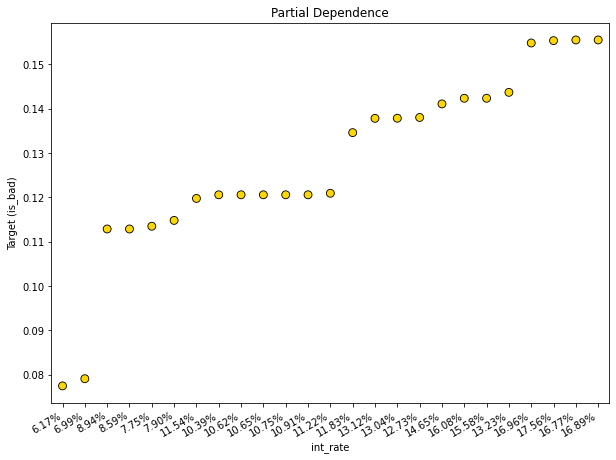

In [7]:
plot, plot_data = partial_dependence(lid, jar, "is_bad", "binary", df.sample(frac=0.1),
                                     'int_rate', ice_plot=False, std_dev_plot=False)

datarobot.codegen_wrapper - INFO - 2021-11-17 10:30:40,249 - ['/Users/timothy.whittaker/.pyenv/versions/3.8.6/envs/mlops/lib/python3.8/site-packages/datarobot/py4j-scoring-assembly-0.1.0-SNAPSHOT.jar', '/Users/timothy.whittaker/Desktop/git/codegen-python/data/5d5da72a3fa59e2850f824fc.jar']
datarobot.codegen_wrapper - INFO - 2021-11-17 10:30:40,251 - java gateway - java -cp /Users/timothy.whittaker/.pyenv/versions/3.8.6/envs/mlops/lib/python3.8/site-packages/datarobot/py4j-scoring-assembly-0.1.0-SNAPSHOT.jar:/Users/timothy.whittaker/Desktop/git/codegen-python/data/5d5da72a3fa59e2850f824fc.jar com.github.timsetsfire.gateway.CodegenGateway 53685 53686 600000 600000 5d5da72a3fa59e2850f824fc
datarobot.codegen_wrapper - INFO - 2021-11-17 10:30:40,260 - starting gateway localhost:53685


loading codegen version of model 5d5da72a3fa59e2850f824fc


datarobot.codegen_wrapper - INFO - 2021-11-17 10:30:41,268 - gateway started localhost:53685


augmented dataset has 25000 rows.
scoring augmented dataset


datarobot.codegen_wrapper - INFO - 2021-11-17 10:31:24,249 - [b'53685,53686,600000,600000,5d5da72a3fa59e2850f824fc\n', b'java port:53685\n', b'python port:53686\n', b'address:localhost/127.0.0.1\n', b'pythonAddress:localhost/127.0.0.1\n', b'starting Gateway\n']


terminating java gateway
Preparing plots


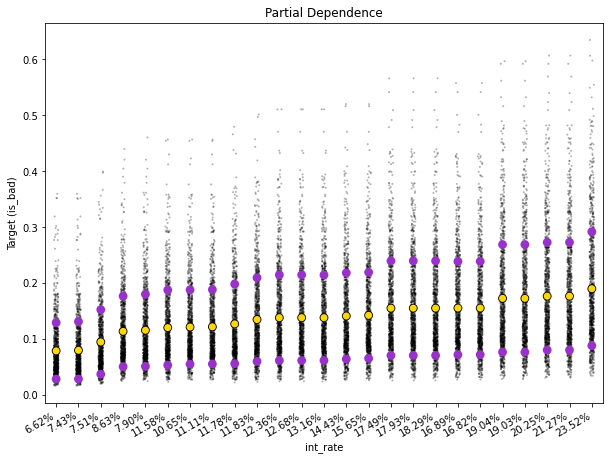

In [8]:
plot, plot_data = partial_dependence(lid, jar, "is_bad", "binary", df,
                                     'int_rate', ice_plot=True, std_dev_plot=True)